In [48]:
import time
import datetime
import json
import os
import pandas as pd
import sys
import pysam
from scipy.special import logsumexp

stderr = sys.stderr
sys.stderr = open('keras.stderr', 'w')

from basepairmodels.cli import argparsers
from basepairmodels.cli import bigwigutils
from basepairmodels.cli import logger
from basepairmodels.cli import MTBatchGenerator

from basepairmodels.cli.batchgenutils import *
from basepairmodels.cli.bpnetutils import *
from basepairmodels.cli.losses import MultichannelMultinomialNLL, multinomial_nll

sys.stderr = stderr

from keras.models import load_model
from keras.utils import CustomObjectScope
from mseqgen import quietexception
from tqdm import tqdm
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import keras.backend as kb

import imageio

from plotnine import *

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [49]:
def get_model(model_path):
    with CustomObjectScope({'MultichannelMultinomialNLL': 
                                MultichannelMultinomialNLL,"kb": kb,
                           "profile_loss": lambda true_vals, pred_vals: pred_vals,
                            "count_loss": lambda true_vals, pred_vals: pred_vals}):
        model = load_model(model_path)
    return model
    
def random_seq(seqlen):
    return ''.join(random.choices("ACGT", k=seqlen))



In [50]:
model_path = '/mnt/lab_data2/vir/tf_chr_atlas/insilco_simulation/FOXA2_singletask_profile_finetune_task0_fold7.h5'
reference_genome = '/users/zahoor/reference/hg38.genome.fa'
peak_path  = '/mnt/lab_data2/vir/tf_chr_atlas/insilco_simulation/FOXA2_task0_peaks.bed.gz'



In [51]:
model = get_model(model_path=model_path)

In [52]:
def dinuc_shuffle(seq, num_shufs=None, rng=None):
    """
    Creates shuffles of the given sequence, in which dinucleotide frequencies
    are preserved.
    Arguments:
        `seq`: either a string of length L, or an L x D NumPy array of one-hot
            encodings
        `num_shufs`: the number of shuffles to create, N; if unspecified, only
            one shuffle will be created
        `rng`: a NumPy RandomState object, to use for performing shuffles
    If `seq` is a string, returns a list of N strings of length L, each one
    being a shuffled version of `seq`. If `seq` is a 2D NumPy array, then the
    result is an N x L x D NumPy array of shuffled versions of `seq`, also
    one-hot encoded. If `num_shufs` is not specified, then the first dimension
    of N will not be present (i.e. a single string will be returned, or an L x D
    array).
    """
    if type(seq) is str:
        arr = string_to_char_array(seq)
    elif type(seq) is np.ndarray and len(seq.shape) == 2:
        seq_len, one_hot_dim = seq.shape
        arr = one_hot_to_tokens(seq)
    else:
        raise ValueError("Expected string or one-hot encoded array")

    if not rng:
        rng = np.random.RandomState()
   
    # Get the set of all characters, and a mapping of which positions have which
    # characters; use `tokens`, which are integer representations of the
    # original characters
    chars, tokens = np.unique(arr, return_inverse=True)

    # For each token, get a list of indices of all the tokens that come after it
    shuf_next_inds = []
    for t in range(len(chars)):
        mask = tokens[:-1] == t  # Excluding last char
        inds = np.where(mask)[0]
        shuf_next_inds.append(inds + 1)  # Add 1 for next token
 
    if type(seq) is str:
        all_results = []
    else:
        all_results = np.empty(
            (num_shufs if num_shufs else 1, seq_len, one_hot_dim),
            dtype=seq.dtype
        )

    for i in range(num_shufs if num_shufs else 1):
        # Shuffle the next indices
        for t in range(len(chars)):
            inds = np.arange(len(shuf_next_inds[t]))
            inds[:-1] = rng.permutation(len(inds) - 1)  # Keep last index same
            shuf_next_inds[t] = shuf_next_inds[t][inds]

        counters = [0] * len(chars)
       
        # Build the resulting array
        ind = 0
        result = np.empty_like(tokens)
        result[0] = tokens[ind]
        for j in range(1, len(tokens)):
            t = tokens[ind]
            ind = shuf_next_inds[t][counters[t]]
            counters[t] += 1
            result[j] = tokens[ind]

        if type(seq) is str:
            all_results.append(char_array_to_string(chars[result]))
        else:
            all_results[i] = tokens_to_one_hot(chars[result], one_hot_dim)
    return all_results if num_shufs else all_results[0]
def string_to_char_array(seq):
    """
    Converts an ASCII string to a NumPy array of byte-long ASCII codes.
    e.g. "ACGT" becomes [65, 67, 71, 84].
    """
    return np.frombuffer(bytearray(seq, "utf8"), dtype=np.int8)


def char_array_to_string(arr):
    """
    Converts a NumPy array of byte-long ASCII codes into an ASCII string.
    e.g. [65, 67, 71, 84] becomes "ACGT".
    """
    return arr.tostring().decode("ascii")


def one_hot_to_tokens(one_hot):
    """
    Converts an L x D one-hot encoding into an L-vector of integers in the range
    [0, D], where the token D is used when the one-hot encoding is all 0. This
    assumes that the one-hot encoding is well-formed, with at most one 1 in each
    column (and 0s elsewhere).
    """
    tokens = np.tile(one_hot.shape[1], one_hot.shape[0])  # Vector of all D
    seq_inds, dim_inds = np.where(one_hot)
    tokens[seq_inds] = dim_inds
    return tokens


def tokens_to_one_hot(tokens, one_hot_dim):
    """
    Converts an L-vector of integers in the range [0, D] to an L x D one-hot
    encoding. The value `D` must be provided as `one_hot_dim`. A token of D
    means the one-hot encoding is all 0s.
    """
    identity = np.identity(one_hot_dim + 1)[:, :-1]  # Last row is all 0s
    return identity[tokens]

In [53]:

def get_suffled_peak_sequences(peak_path,fasta_path = '/users/zahoor/reference/hg38.genome.fa', input_seq_len = 2114,
                               num_of_simulated_sequences=1000):
    peaks_df = pd.read_csv(peak_path,
                           sep='\t',header=None,
                           names=['chrom', 'start', 'end', 'name', 'score',
                                      'strand', 'signalValue', 'p', 'q', 'summit'])

    peaks_df = peaks_df.sample(frac=1).reset_index(drop=True)

    fasta_ref = pysam.FastaFile(fasta_path)

    sequences = []

    Input_start = peaks_df['start'] + peaks_df['summit'] - (input_seq_len//2)
    Input_start = Input_start.mask(Input_start < 0,0)
    Input_end = peaks_df['start'] + peaks_df['summit'] + (input_seq_len//2)


    for i in range(num_of_simulated_sequences):
        actual_sequence = fasta_ref.fetch(peaks_df['chrom'][i], Input_start[i] , Input_end[i]).upper()
        padded_sequence = actual_sequence+(random_seq(input_seq_len-len(actual_sequence)))
        shuffled_seq = dinuc_shuffle(padded_sequence)
        sequences.append(shuffled_seq)
    
    return sequences

In [54]:
sequences = get_suffled_peak_sequences(peak_path)

/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/ipykernel_launcher.py:86: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


In [55]:
def logits_to_profile(logits_vals,counts_vals):
    probVals = logits_vals - logsumexp(logits_vals)
    probVals = np.exp(probVals)
    profile = np.multiply(np.exp(counts_vals)-1, probVals)
    return profile



In [56]:
def calculate_average_profile(prediction,task=0):
    plus = []
    minus = []

    for i in range(len(prediction[1])):
        minus.append(logits_to_profile(logits_vals = prediction[0][i][task,:,0],counts_vals = prediction[1][i][task,0]))
        plus.append(logits_to_profile(logits_vals = prediction[0][i][task,:,1],counts_vals = prediction[1][i][task,1]))
    plus_avg = np.vstack(plus).mean(axis=0)
    minus_avg = np.vstack(minus).mean(axis=0)
    return(plus_avg,minus_avg)

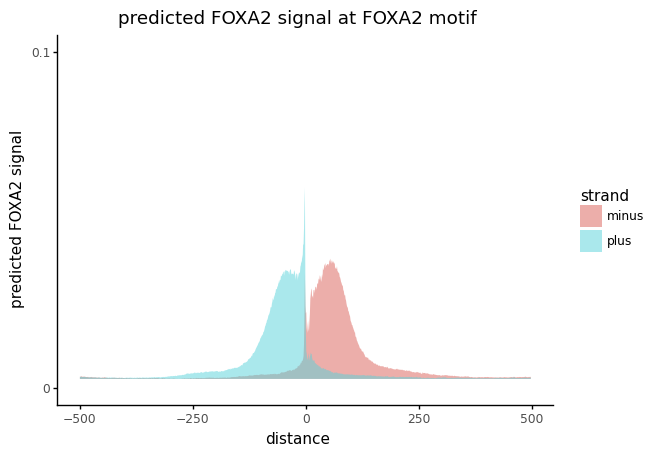

<ggplot: (8739896724741)>


/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: FOXA2 motif - FOXA2.pdf


In [57]:
output_seq_len = 1000
number_of_strands = 2
input_seq_len = 2114
task = 0
num_of_tasks = 1

motif = 'TGTTTACTTA'
input_seq_len = 2114
motif_inserted_sequences = []
for sequence in sequences:
    inserted_sequence = (sequence[:(input_seq_len//2)] 
                        + motif 
                        + sequence[(input_seq_len//2)+len(motif):])
    motif_inserted_sequences.append(inserted_sequence+random_seq(input_seq_len-len(inserted_sequence)))
    
encoded_inserted_sequences = one_hot_encode(motif_inserted_sequences)

prediction = model.predict([encoded_inserted_sequences,
                   np.zeros(num_of_tasks*output_seq_len*number_of_strands*encoded_inserted_sequences.shape[0]).reshape((encoded_inserted_sequences.shape[0],num_of_tasks,output_seq_len,number_of_strands))])



plus,minus = calculate_average_profile(prediction,task=task)

data = pd.DataFrame([plus,minus,np.array(range(-500,499),dtype='int32')]).T
data.columns = ['plus','minus','distance']

data = pd.melt(data,id_vars='distance', 
           value_vars=['plus', 'minus'], 
           var_name='strand', 
           value_name='predicted signal')

ymin=min(data['predicted signal'])
plot=(ggplot(data,aes('distance'))
         +geom_ribbon(aes(ymin=ymin,ymax='predicted signal',fill='strand'),alpha=0.5)
         +theme_classic()
         +scale_y_continuous(name ="predicted FOXA2 signal",limits=(0,0.1),breaks=(0,0.1))
         +labs(title="predicted FOXA2 signal at FOXA2 motif")  
     )
print(plot)
plot.save("FOXA2 motif - FOXA2.pdf")

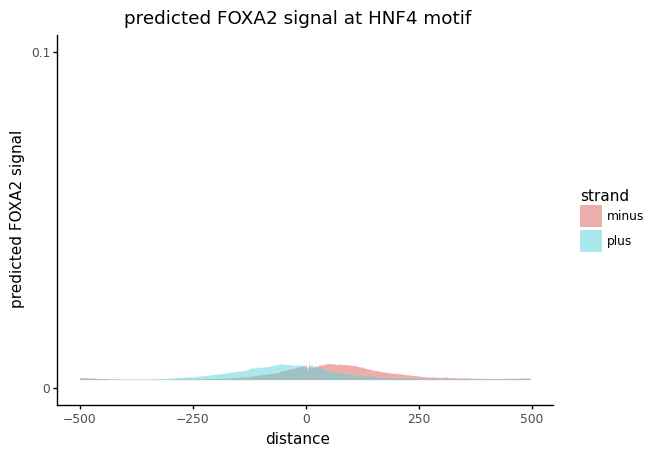

<ggplot: (8739896332165)>


/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: HNF4 motif - FOXA2.pdf


In [58]:
motif = 'TGAACTTTGAAC'
motif_inserted_sequences = []
for sequence in sequences:
    inserted_sequence = (sequence[:(input_seq_len//2)] 
                        + motif 
                        + sequence[(input_seq_len//2)+len(motif):])
    motif_inserted_sequences.append(inserted_sequence+random_seq(input_seq_len-len(inserted_sequence)))
    
encoded_inserted_sequences = one_hot_encode(motif_inserted_sequences)

prediction = model.predict([encoded_inserted_sequences,
                   np.zeros(num_of_tasks*output_seq_len*number_of_strands*encoded_inserted_sequences.shape[0]).reshape((encoded_inserted_sequences.shape[0],num_of_tasks,output_seq_len,number_of_strands))])



plus,minus = calculate_average_profile(prediction,task=task)

data = pd.DataFrame([plus,minus,np.array(range(-500,499),dtype='int32')]).T
data.columns = ['plus','minus','distance']

data = pd.melt(data,id_vars='distance', 
           value_vars=['plus', 'minus'], 
           var_name='strand', 
           value_name='predicted signal')

ymin=min(data['predicted signal'])
plot=(ggplot(data,aes('distance'))
         +geom_ribbon(aes(ymin=ymin,ymax='predicted signal',fill='strand'),alpha=0.5)
         +theme_classic()
         +scale_y_continuous(name ="predicted FOXA2 signal",limits=(0,0.1),breaks=(0,0.1))
         +labs(title="predicted FOXA2 signal at HNF4 motif")  
     )
print(plot)
plot.save("HNF4 motif - FOXA2.pdf")

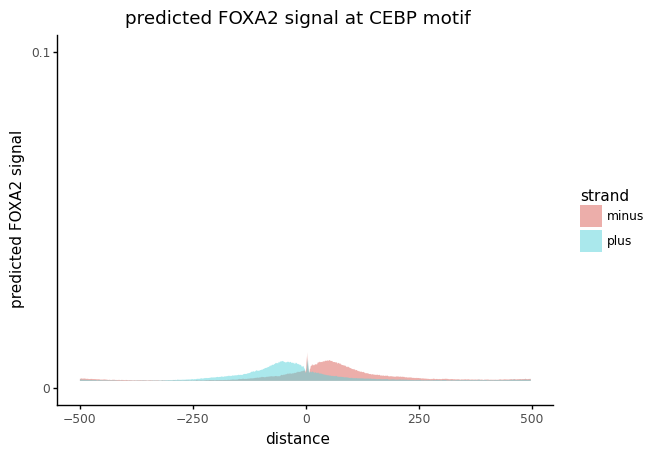

<ggplot: (8739896288053)>


/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: CEBP motif - FOXA2.pdf


In [59]:
motif = 'TTGCGCAA'
motif_inserted_sequences = []
for sequence in sequences:
    inserted_sequence = (sequence[:(input_seq_len//2)] 
                        + motif 
                        + sequence[(input_seq_len//2)+len(motif):])
    motif_inserted_sequences.append(inserted_sequence+random_seq(input_seq_len-len(inserted_sequence)))
    
encoded_inserted_sequences = one_hot_encode(motif_inserted_sequences)

prediction = model.predict([encoded_inserted_sequences,
                   np.zeros(num_of_tasks*output_seq_len*number_of_strands*encoded_inserted_sequences.shape[0]).reshape((encoded_inserted_sequences.shape[0],num_of_tasks,output_seq_len,number_of_strands))])



plus,minus = calculate_average_profile(prediction,task=task)

data = pd.DataFrame([plus,minus,np.array(range(-500,499),dtype='int32')]).T
data.columns = ['plus','minus','distance']

data = pd.melt(data,id_vars='distance', 
           value_vars=['plus', 'minus'], 
           var_name='strand', 
           value_name='predicted signal')

ymin=min(data['predicted signal'])
plot=(ggplot(data,aes('distance'))
         +geom_ribbon(aes(ymin=ymin,ymax='predicted signal',fill='strand'),alpha=0.5)
         +theme_classic()
         +scale_y_continuous(name ="predicted FOXA2 signal",limits=(0,0.1),breaks=(0,0.1))
         +labs(title="predicted FOXA2 signal at CEBP motif")  
     )
print(plot)
plot.save("CEBP motif - FOXA2.pdf")

In [60]:
max_distance = 200
from tqdm import trange, tqdm
    

def get_suffled_peak_sequences(peak_path,fasta_path = '/users/zahoor/reference/hg38.genome.fa', input_seq_len = 2114,
                               num_of_simulated_sequences=1000):
    peaks_df = pd.read_csv(peak_path,
                           sep='\t',header=None,
                           names=['chrom', 'start', 'end', 'name', 'score',
                                      'strand', 'signalValue', 'p', 'q', 'summit'])

    peaks_df = peaks_df.sample(frac=1).reset_index(drop=True)

    fasta_ref = pysam.FastaFile(fasta_path)

    sequences = []

    Input_start = peaks_df['start'] + peaks_df['summit'] - (input_seq_len//2)
    Input_start = Input_start.mask(Input_start < 0,0)
    Input_end = peaks_df['start'] + peaks_df['summit'] + (input_seq_len//2)


    for i in range(num_of_simulated_sequences):
        actual_sequence = fasta_ref.fetch(peaks_df['chrom'][i], Input_start[i] , Input_end[i]).upper()
        padded_sequence = actual_sequence+(random_seq(input_seq_len-len(actual_sequence)))
        shuffled_seq = dinuc_shuffle(padded_sequence)
        sequences.append(shuffled_seq)
    
    return sequences

def predict_logits(encoded_inserted_sequences,output_seq_len = 1000,number_of_strands = 2,task=0,num_of_tasks=1):
    
    prediction = model.predict([encoded_inserted_sequences,
                   np.zeros(num_of_tasks*output_seq_len*number_of_strands*encoded_inserted_sequences.shape[0]).reshape((encoded_inserted_sequences.shape[0],num_of_tasks,output_seq_len,number_of_strands))])

    return prediction


def calculate_max_signal(prediction,max_signal_window,task=0):
    plus = []
    minus = []

    for i in range(len(prediction[1])):
        minus.append(logits_to_profile(logits_vals = prediction[0][i][task,:,0],counts_vals = prediction[1][i][task,0]))
        plus.append(logits_to_profile(logits_vals = prediction[0][i][task,:,1],counts_vals = prediction[1][i][task,1]))
    plus_max_avg = np.vstack(plus)[:,(output_seq_len//2)-(max_signal_window//2):(output_seq_len//2)+(max_signal_window//2)].max(axis=1).mean()
    minus_max_avg = np.vstack(minus)[:,(output_seq_len//2)-(max_signal_window//2):(output_seq_len//2)+(max_signal_window//2)].max(axis=1).mean()

    return(max(plus_max_avg,minus_max_avg))

def calculate_mean_signal(prediction,signal_window=70,task=0):
    plus = []
    minus = []

    for i in range(len(prediction[1])):
        minus.append(logits_to_profile(logits_vals = prediction[0][i][task,:,0],counts_vals = prediction[1][i][task,0]))
        plus.append(logits_to_profile(logits_vals = prediction[0][i][task,:,1],counts_vals = prediction[1][i][task,1]))
    plus_mean_avg = np.vstack(plus)[:,(output_seq_len//2)-(signal_window//2):(output_seq_len//2)+(signal_window//2)].mean(axis=1).mean()
    minus_mean_avg = np.vstack(minus)[:,(output_seq_len//2)-(signal_window//2):(output_seq_len//2)+(signal_window//2)].mean(axis=1).mean()

    return(max(plus_mean_avg,minus_mean_avg))

    
def insert_two_motif_with_distance(motif_1,motif_2,distance,sequences):
    motif_inserted_sequences = []
    for sequence in sequences:
        inserted_sequence = (sequence[:(input_seq_len//2)] 
                            +motif_1 
                            +sequence[(input_seq_len//2)+len(motif_1):(input_seq_len//2)+len(motif_1)+distance]
                            +motif_2
                            +sequence[(input_seq_len//2)+len(motif_1)+distance+len(motif_2):])
        motif_inserted_sequences.append(inserted_sequence+random_seq(input_seq_len-len(inserted_sequence)))
    return motif_inserted_sequences

def simulate_distance_interaction(model,motif_1,motif_2,max_distance=200,signal_window=70,task=0,num_of_tasks=1,return_fold_change=False):
    if return_fold_change==False: # will return actual signal for the different distance
        sequences = get_suffled_peak_sequences(peak_path, reference_genome, 2114, 100)
        max_signal = []
        for motif_distance in trange(0,max_distance,1):
            motif_inserted_sequences = insert_two_motif_with_distance(motif_1=motif_1,
                                                                      motif_2=motif_2,
                                                                      distance=motif_distance,
                                                                      sequences=sequences)
            encoded_inserted_sequences = one_hot_encode(motif_inserted_sequences)
            prediction = predict_logits(encoded_inserted_sequences = encoded_inserted_sequences,
                                        output_seq_len = 1000,
                                        number_of_strands = 2,task=task,num_of_tasks=num_of_tasks)
            max_signal.append((motif_distance,calculate_mean_signal(prediction,signal_window,task=task)))
        return(max_signal)
    if return_fold_change:  # will return fold change over expectation for the different distance  
        # expectation: 
        sequences = get_suffled_peak_sequences(peak_path, reference_genome, 2114, 100)
        max_signal = []
        
        #motif1 baseline
        motif_inserted_sequences = insert_two_motif_with_distance(motif_1=motif_1,
                                                                  motif_2='',
                                                                  distance=0,
                                                                  sequences=sequences)
        encoded_inserted_sequences = one_hot_encode(motif_inserted_sequences)
        prediction = predict_logits(encoded_inserted_sequences = encoded_inserted_sequences,
                                    output_seq_len = 1000,
                                    number_of_strands = 2,task=task,num_of_tasks=num_of_tasks)

        motif1_baseline = calculate_mean_signal(prediction,signal_window,task=task)
            
        #nomotif background
        motif_inserted_sequences = insert_two_motif_with_distance(motif_1='',
                                                                  motif_2='',
                                                                  distance=0,
                                                                  sequences=sequences)
        encoded_inserted_sequences = one_hot_encode(motif_inserted_sequences)
        prediction = predict_logits(encoded_inserted_sequences = encoded_inserted_sequences,
                                    output_seq_len = 1000,
                                    number_of_strands = 2,task=task,num_of_tasks=num_of_tasks)

        background = calculate_mean_signal(prediction,signal_window,task=task)
        
        for motif_distance in trange(0,max_distance,1):
            #actual signal
            motif_inserted_sequences = insert_two_motif_with_distance(motif_1=motif_1,
                                                                      motif_2=motif_2,
                                                                      distance=motif_distance,
                                                                      sequences=sequences)
            encoded_inserted_sequences = one_hot_encode(motif_inserted_sequences)
            prediction = predict_logits(encoded_inserted_sequences = encoded_inserted_sequences,
                                        output_seq_len = 1000,
                                        number_of_strands = 2,task=task,num_of_tasks=num_of_tasks)
            
            signal = calculate_mean_signal(prediction,signal_window,task=task)
            
            
            
            #motif2 background
            motif_inserted_sequences = insert_two_motif_with_distance(motif_1='',
                                                                      motif_2=motif_2,
                                                                      distance=motif_distance+len(motif_1),
                                                                      sequences=sequences)
            encoded_inserted_sequences = one_hot_encode(motif_inserted_sequences)
            prediction = predict_logits(encoded_inserted_sequences = encoded_inserted_sequences,
                                        output_seq_len = 1000,
                                        number_of_strands = 2,task=task,num_of_tasks=num_of_tasks)
            
            motif2_background = calculate_mean_signal(prediction,signal_window,task=task)
            
            
#           max_signal.append((motif_distance,(signal-motif2_background)/(motif1_baseline-background)))
            
            max_signal.append((motif_distance,(signal-motif2_background+background)/(motif1_baseline)))
        return(max_signal)
        

/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/ipykernel_launcher.py:86: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


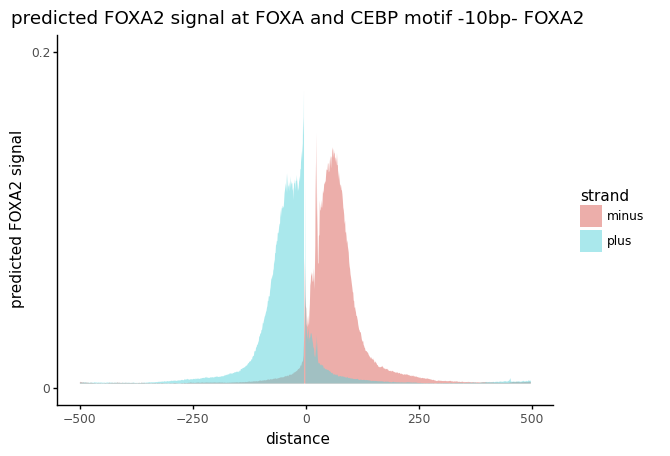

<ggplot: (8739896752737)>


/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: FOXA and CEBP motif -10bp- FOXA2.pdf


In [61]:
output_seq_len = 1000
number_of_strands = 2


motif1 = 'TGTTTACTTA'
motif2 = 'TTGCGCAA'

input_seq_len = 2114
motif_inserted_sequences = []

sequences = get_suffled_peak_sequences(peak_path, reference_genome, 2114, 200)

motif_inserted_sequences = insert_two_motif_with_distance(motif_1=motif1,
                                                                  motif_2=motif2,
                                                                  distance=10,
                                                                  sequences=sequences)
encoded_inserted_sequences = one_hot_encode(motif_inserted_sequences)

prediction = model.predict([encoded_inserted_sequences,
               np.zeros(output_seq_len*number_of_strands*encoded_inserted_sequences.shape[0]).reshape((encoded_inserted_sequences.shape[0],1,output_seq_len,number_of_strands))])


plus,minus = calculate_average_profile(prediction)

data = pd.DataFrame([plus,minus,np.array(range(-500,499),dtype='int32')]).T
data.columns = ['plus','minus','distance']

data = pd.melt(data,id_vars='distance', 
           value_vars=['plus', 'minus'], 
           var_name='strand', 
           value_name='predicted signal')

ymin=min(data['predicted signal'])
plot=(ggplot(data,aes('distance'))
         +geom_ribbon(aes(ymin=ymin,ymax='predicted signal',fill='strand'),alpha=0.5)
         +theme_classic()
         +scale_y_continuous(name ="predicted FOXA2 signal",limits=(0,0.2),breaks=(0,0.2))
         +labs(title="predicted FOXA2 signal at FOXA and CEBP motif -10bp- FOXA2")  
     )
print(plot)
plot.save("FOXA and CEBP motif -10bp- FOXA2.pdf")

/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/ipykernel_launcher.py:86: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


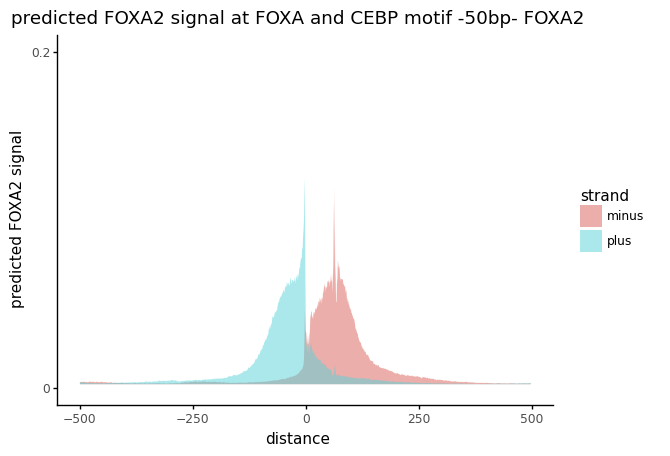

<ggplot: (8739902665317)>


/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: FOXA and CEBP motif -50bp- FOXA2.pdf


In [62]:
output_seq_len = 1000
number_of_strands = 2


motif1 = 'TGTTTACTTA'
motif2 = 'TTGCGCAA'

input_seq_len = 2114
motif_inserted_sequences = []

sequences = get_suffled_peak_sequences(peak_path, reference_genome, 2114, 200)

motif_inserted_sequences = insert_two_motif_with_distance(motif_1=motif1,
                                                                  motif_2=motif2,
                                                                  distance=50,
                                                                  sequences=sequences)
encoded_inserted_sequences = one_hot_encode(motif_inserted_sequences)

prediction = model.predict([encoded_inserted_sequences,
               np.zeros(output_seq_len*number_of_strands*encoded_inserted_sequences.shape[0]).reshape((encoded_inserted_sequences.shape[0],1,output_seq_len,number_of_strands))])


plus,minus = calculate_average_profile(prediction)

data = pd.DataFrame([plus,minus,np.array(range(-500,499),dtype='int32')]).T
data.columns = ['plus','minus','distance']

data = pd.melt(data,id_vars='distance', 
           value_vars=['plus', 'minus'], 
           var_name='strand', 
           value_name='predicted signal')

ymin=min(data['predicted signal'])
plot=(ggplot(data,aes('distance'))
         +geom_ribbon(aes(ymin=ymin,ymax='predicted signal',fill='strand'),alpha=0.5)
         +theme_classic()
         +scale_y_continuous(name ="predicted FOXA2 signal",limits=(0,0.2),breaks=(0,0.2))
         +labs(title="predicted FOXA2 signal at FOXA and CEBP motif -50bp- FOXA2")  
     )
print(plot)
plot.save("FOXA and CEBP motif -50bp- FOXA2.pdf")

/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/ipykernel_launcher.py:86: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


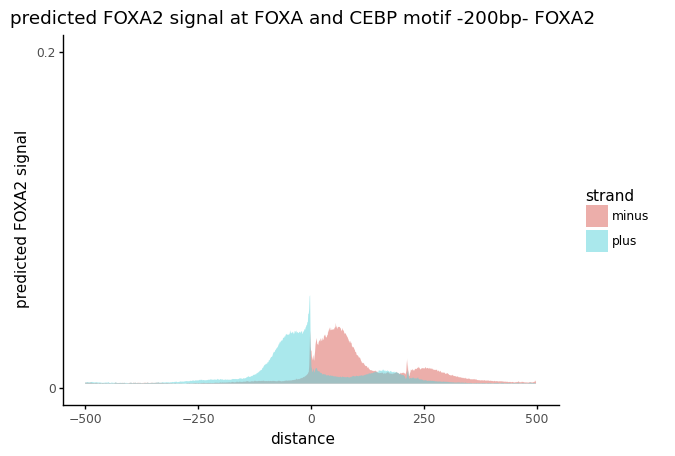

<ggplot: (8739896096913)>


/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: FOXA and CEBP motif -200bp- FOXA2.pdf


In [63]:
output_seq_len = 1000
number_of_strands = 2


motif1 = 'TGTTTACTTA'
motif2 = 'TTGCGCAA'

input_seq_len = 2114
motif_inserted_sequences = []

sequences = get_suffled_peak_sequences(peak_path, reference_genome, 2114, 200)

motif_inserted_sequences = insert_two_motif_with_distance(motif_1=motif1,
                                                                  motif_2=motif2,
                                                                  distance=200,
                                                                  sequences=sequences)
encoded_inserted_sequences = one_hot_encode(motif_inserted_sequences)

prediction = model.predict([encoded_inserted_sequences,
               np.zeros(output_seq_len*number_of_strands*encoded_inserted_sequences.shape[0]).reshape((encoded_inserted_sequences.shape[0],1,output_seq_len,number_of_strands))])


plus,minus = calculate_average_profile(prediction)

data = pd.DataFrame([plus,minus,np.array(range(-500,499),dtype='int32')]).T
data.columns = ['plus','minus','distance']

data = pd.melt(data,id_vars='distance', 
           value_vars=['plus', 'minus'], 
           var_name='strand', 
           value_name='predicted signal')

ymin=min(data['predicted signal'])
plot=(ggplot(data,aes('distance'))
         +geom_ribbon(aes(ymin=ymin,ymax='predicted signal',fill='strand'),alpha=0.5)
         +theme_classic()
         +scale_y_continuous(name ="predicted FOXA2 signal",limits=(0,0.2),breaks=(0,0.2))
         +labs(title="predicted FOXA2 signal at FOXA and CEBP motif -200bp- FOXA2")  
     )
print(plot)
plot.save("FOXA and CEBP motif -200bp- FOXA2.pdf")

/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/ipykernel_launcher.py:86: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
100%|██████████| 200/200 [01:03<00:00,  3.17it/s]


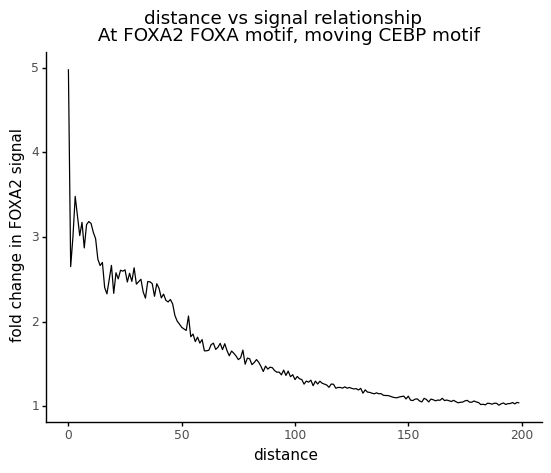

<ggplot: (8739902631501)>


/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: FOXA2 FOXA motif, moving CEBP motif plot.pdf


In [64]:
factor = 'FOXA2'
motif1 = {'motif':'TGTTTACTTA','name':'FOXA motif'}
motif2 = {'motif':'TTGCGCAA','name':'CEBP motif'}

distance_signal_lst = simulate_distance_interaction(model,motif1['motif'],motif2['motif'],max_distance=200,task=task,num_of_tasks=num_of_tasks,return_fold_change=True)
distance_signal_df = pd.DataFrame(distance_signal_lst, columns=['distance', 'signal'])

plot=(ggplot(distance_signal_df,aes('distance','signal'))
         +geom_line()
         +theme_classic()
         +scale_y_continuous(name =f"fold change in {factor} signal")
         +labs(title=f"distance vs signal relationship \n At {factor} {motif1['name']}, moving {motif2['name']}")  
     )
print(plot)
plot.save(f"{factor} {motif1['name']}, moving {motif2['name']} plot.pdf")

/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/ipykernel_launcher.py:86: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


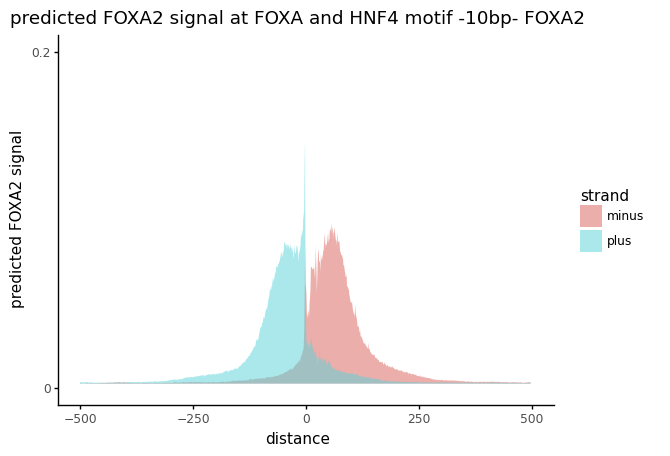

<ggplot: (8739902068881)>


/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: FOXA and HNF4 motif -10bp- FOXA2.pdf


In [65]:
output_seq_len = 1000
number_of_strands = 2


motif1 = 'TGTTTACTTA'
motif2 = 'TGAACTTTGAAC'

input_seq_len = 2114
motif_inserted_sequences = []

sequences = get_suffled_peak_sequences(peak_path, reference_genome, 2114, 200)

motif_inserted_sequences = insert_two_motif_with_distance(motif_1=motif1,
                                                                  motif_2=motif2,
                                                                  distance=10,
                                                                  sequences=sequences)
encoded_inserted_sequences = one_hot_encode(motif_inserted_sequences)

prediction = model.predict([encoded_inserted_sequences,
               np.zeros(output_seq_len*number_of_strands*encoded_inserted_sequences.shape[0]).reshape((encoded_inserted_sequences.shape[0],1,output_seq_len,number_of_strands))])


plus,minus = calculate_average_profile(prediction)

data = pd.DataFrame([plus,minus,np.array(range(-500,499),dtype='int32')]).T
data.columns = ['plus','minus','distance']

data = pd.melt(data,id_vars='distance', 
           value_vars=['plus', 'minus'], 
           var_name='strand', 
           value_name='predicted signal')

ymin=min(data['predicted signal'])
plot=(ggplot(data,aes('distance'))
         +geom_ribbon(aes(ymin=ymin,ymax='predicted signal',fill='strand'),alpha=0.5)
         +theme_classic()
         +scale_y_continuous(name ="predicted FOXA2 signal",limits=(0,0.2),breaks=(0,0.2))
         +labs(title="predicted FOXA2 signal at FOXA and HNF4 motif -10bp- FOXA2")  
     )
print(plot)
plot.save("FOXA and HNF4 motif -10bp- FOXA2.pdf")

/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/ipykernel_launcher.py:86: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


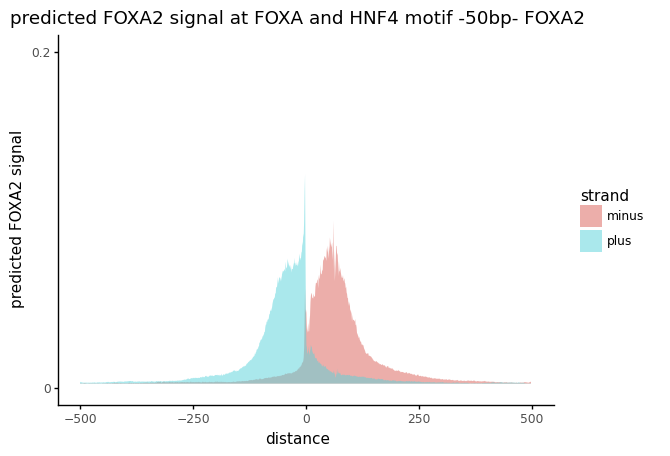

<ggplot: (8739895910973)>


/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: FOXA and HNF4 motif -50bp- FOXA2.pdf


In [66]:
output_seq_len = 1000
number_of_strands = 2


motif1 = 'TGTTTACTTA'
motif2 = 'TGAACTTTGAAC'

input_seq_len = 2114
motif_inserted_sequences = []

sequences = get_suffled_peak_sequences(peak_path, reference_genome, 2114, 200)

motif_inserted_sequences = insert_two_motif_with_distance(motif_1=motif1,
                                                                  motif_2=motif2,
                                                                  distance=50,
                                                                  sequences=sequences)
encoded_inserted_sequences = one_hot_encode(motif_inserted_sequences)

prediction = model.predict([encoded_inserted_sequences,
               np.zeros(output_seq_len*number_of_strands*encoded_inserted_sequences.shape[0]).reshape((encoded_inserted_sequences.shape[0],1,output_seq_len,number_of_strands))])


plus,minus = calculate_average_profile(prediction)

data = pd.DataFrame([plus,minus,np.array(range(-500,499),dtype='int32')]).T
data.columns = ['plus','minus','distance']

data = pd.melt(data,id_vars='distance', 
           value_vars=['plus', 'minus'], 
           var_name='strand', 
           value_name='predicted signal')

ymin=min(data['predicted signal'])
plot=(ggplot(data,aes('distance'))
         +geom_ribbon(aes(ymin=ymin,ymax='predicted signal',fill='strand'),alpha=0.5)
         +theme_classic()
         +scale_y_continuous(name ="predicted FOXA2 signal",limits=(0,0.2),breaks=(0,0.2))
         +labs(title="predicted FOXA2 signal at FOXA and HNF4 motif -50bp- FOXA2")  
     )
print(plot)
plot.save("FOXA and HNF4 motif -50bp- FOXA2.pdf")

/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/ipykernel_launcher.py:86: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


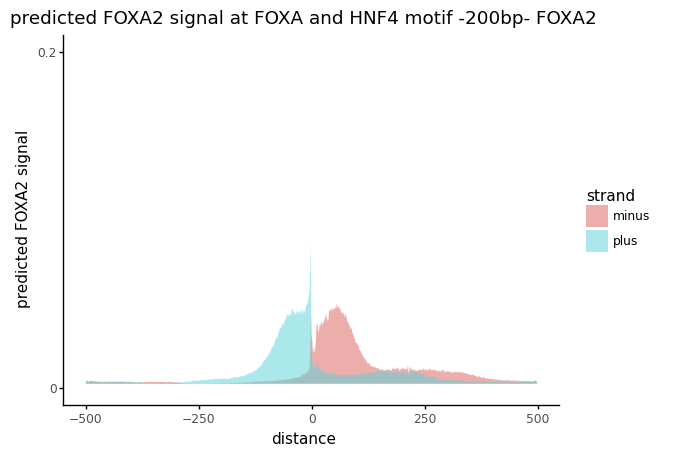

<ggplot: (8739896337877)>


/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: FOXA and HNF4 motif -200bp- FOXA2.pdf


In [67]:
output_seq_len = 1000
number_of_strands = 2


motif1 = 'TGTTTACTTA'
motif2 = 'TGAACTTTGAAC'

input_seq_len = 2114
motif_inserted_sequences = []

sequences = get_suffled_peak_sequences(peak_path, reference_genome, 2114, 200)

motif_inserted_sequences = insert_two_motif_with_distance(motif_1=motif1,
                                                                  motif_2=motif2,
                                                                  distance=200,
                                                                  sequences=sequences)
encoded_inserted_sequences = one_hot_encode(motif_inserted_sequences)

prediction = model.predict([encoded_inserted_sequences,
               np.zeros(output_seq_len*number_of_strands*encoded_inserted_sequences.shape[0]).reshape((encoded_inserted_sequences.shape[0],1,output_seq_len,number_of_strands))])


plus,minus = calculate_average_profile(prediction)

data = pd.DataFrame([plus,minus,np.array(range(-500,499),dtype='int32')]).T
data.columns = ['plus','minus','distance']

data = pd.melt(data,id_vars='distance', 
           value_vars=['plus', 'minus'], 
           var_name='strand', 
           value_name='predicted signal')

ymin=min(data['predicted signal'])
plot=(ggplot(data,aes('distance'))
         +geom_ribbon(aes(ymin=ymin,ymax='predicted signal',fill='strand'),alpha=0.5)
         +theme_classic()
         +scale_y_continuous(name ="predicted FOXA2 signal",limits=(0,0.2),breaks=(0,0.2))
         +labs(title="predicted FOXA2 signal at FOXA and HNF4 motif -200bp- FOXA2")  
     )
print(plot)
plot.save("FOXA and HNF4 motif -200bp- FOXA2.pdf")

/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/ipykernel_launcher.py:86: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
100%|██████████| 200/200 [01:05<00:00,  3.06it/s]


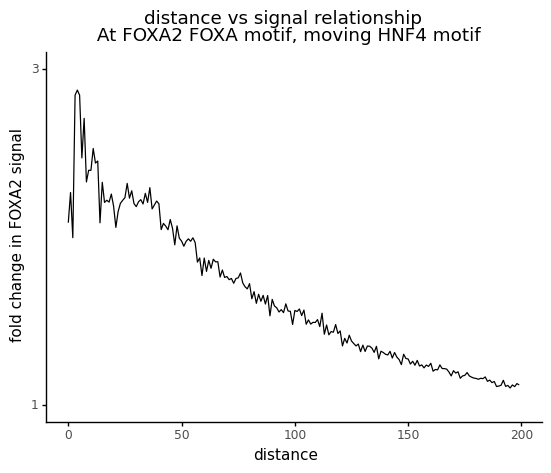

<ggplot: (8739897495293)>


/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: FOXA2 FOXA motif, moving HNF4 motif plot.pdf


In [75]:
factor = 'FOXA2'
motif1 = {'motif':'TGTTTACTTA','name':'FOXA motif'}
motif2 = {'motif':'TGAACTTTGAAC','name':'HNF4 motif'}

distance_signal_lst = simulate_distance_interaction(model,motif1['motif'],motif2['motif'],max_distance=200,task=task,num_of_tasks=num_of_tasks,return_fold_change=True)
distance_signal_df = pd.DataFrame(distance_signal_lst, columns=['distance', 'signal'])

plot=(ggplot(distance_signal_df,aes('distance','signal'))
         +geom_line()
         +theme_classic()
         +scale_y_continuous(name =f"fold change in {factor} signal",breaks=(1,3))
         +labs(title=f"distance vs signal relationship \n At {factor} {motif1['name']}, moving {motif2['name']}")  
     )
print(plot)
plot.save(f"{factor} {motif1['name']}, moving {motif2['name']} plot.pdf")

/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/ipykernel_launcher.py:86: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
100%|██████████| 200/200 [01:04<00:00,  3.11it/s]


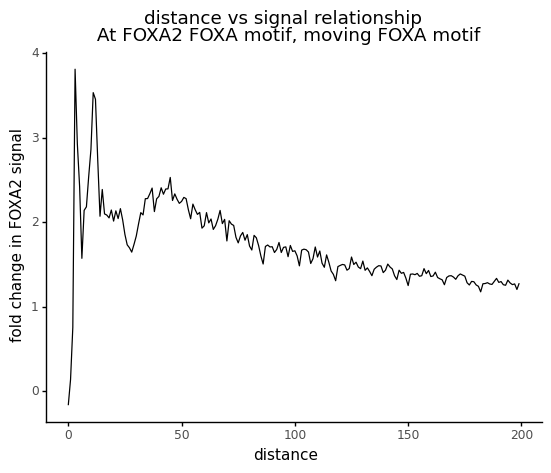

<ggplot: (8739895777017)>


/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: FOXA2 FOXA motif, moving FOXA motif plot.pdf


In [69]:
factor = 'FOXA2'
motif1 = {'motif':'TGTTTACTTA','name':'FOXA motif'}
motif2 = {'motif':'TGTTTACTTA','name':'FOXA motif'}

distance_signal_lst = simulate_distance_interaction(model,motif1['motif'],motif2['motif'],max_distance=200,task=task,num_of_tasks=num_of_tasks,return_fold_change=True)
distance_signal_df = pd.DataFrame(distance_signal_lst, columns=['distance', 'signal'])

plot=(ggplot(distance_signal_df,aes('distance','signal'))
         +geom_line()
         +theme_classic()
         +scale_y_continuous(name =f"fold change in {factor} signal")
         +labs(title=f"distance vs signal relationship \n At {factor} {motif1['name']}, moving {motif2['name']}")  
     )
print(plot)
plot.save(f"{factor} {motif1['name']}, moving {motif2['name']} plot.pdf")

/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/ipykernel_launcher.py:86: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


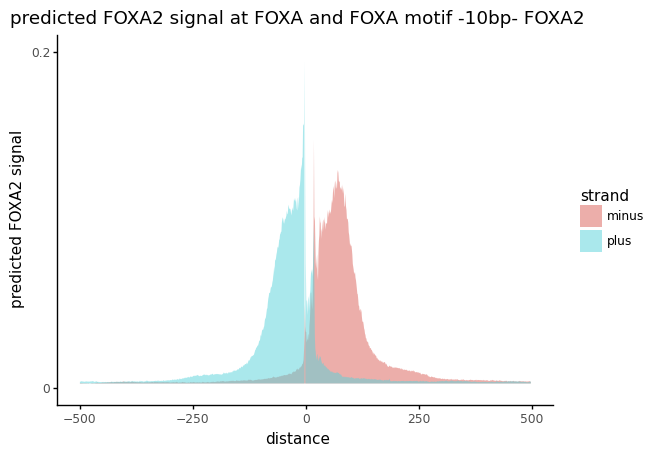

<ggplot: (8739895827145)>


/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: FOXA and FOXA motif -10bp- FOXA2.pdf


In [70]:
output_seq_len = 1000
number_of_strands = 2


motif1 = 'TGTTTACTTA'
motif2 = 'TGTTTACTTA'

input_seq_len = 2114
motif_inserted_sequences = []

sequences = get_suffled_peak_sequences(peak_path, reference_genome, 2114, 200)

motif_inserted_sequences = insert_two_motif_with_distance(motif_1=motif1,
                                                                  motif_2=motif2,
                                                                  distance=10,
                                                                  sequences=sequences)
encoded_inserted_sequences = one_hot_encode(motif_inserted_sequences)

prediction = model.predict([encoded_inserted_sequences,
               np.zeros(output_seq_len*number_of_strands*encoded_inserted_sequences.shape[0]).reshape((encoded_inserted_sequences.shape[0],1,output_seq_len,number_of_strands))])


plus,minus = calculate_average_profile(prediction)

data = pd.DataFrame([plus,minus,np.array(range(-500,499),dtype='int32')]).T
data.columns = ['plus','minus','distance']

data = pd.melt(data,id_vars='distance', 
           value_vars=['plus', 'minus'], 
           var_name='strand', 
           value_name='predicted signal')

ymin=min(data['predicted signal'])
plot=(ggplot(data,aes('distance'))
         +geom_ribbon(aes(ymin=ymin,ymax='predicted signal',fill='strand'),alpha=0.5)
         +theme_classic()
         +scale_y_continuous(name ="predicted FOXA2 signal",limits=(0,0.2),breaks=(0,0.2))
         +labs(title="predicted FOXA2 signal at FOXA and FOXA motif -10bp- FOXA2")  
     )
print(plot)
plot.save("FOXA and FOXA motif -10bp- FOXA2.pdf")

/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/ipykernel_launcher.py:86: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


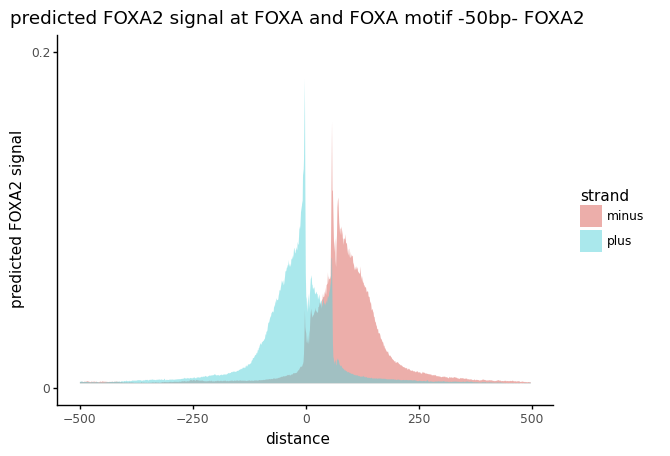

<ggplot: (8739895861181)>


/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: FOXA and FOXA motif -50bp- FOXA2.pdf


In [71]:
output_seq_len = 1000
number_of_strands = 2


motif1 = 'TGTTTACTTA'
motif2 = 'TGTTTACTTA'

input_seq_len = 2114
motif_inserted_sequences = []

sequences = get_suffled_peak_sequences(peak_path, reference_genome, 2114, 200)

motif_inserted_sequences = insert_two_motif_with_distance(motif_1=motif1,
                                                                  motif_2=motif2,
                                                                  distance=50,
                                                                  sequences=sequences)
encoded_inserted_sequences = one_hot_encode(motif_inserted_sequences)

prediction = model.predict([encoded_inserted_sequences,
               np.zeros(output_seq_len*number_of_strands*encoded_inserted_sequences.shape[0]).reshape((encoded_inserted_sequences.shape[0],1,output_seq_len,number_of_strands))])


plus,minus = calculate_average_profile(prediction)

data = pd.DataFrame([plus,minus,np.array(range(-500,499),dtype='int32')]).T
data.columns = ['plus','minus','distance']

data = pd.melt(data,id_vars='distance', 
           value_vars=['plus', 'minus'], 
           var_name='strand', 
           value_name='predicted signal')

ymin=min(data['predicted signal'])
plot=(ggplot(data,aes('distance'))
         +geom_ribbon(aes(ymin=ymin,ymax='predicted signal',fill='strand'),alpha=0.5)
         +theme_classic()
         +scale_y_continuous(name ="predicted FOXA2 signal",limits=(0,0.2),breaks=(0,0.2))
         +labs(title="predicted FOXA2 signal at FOXA and FOXA motif -50bp- FOXA2")  
     )
print(plot)
plot.save("FOXA and FOXA motif -50bp- FOXA2.pdf")

/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/ipykernel_launcher.py:86: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


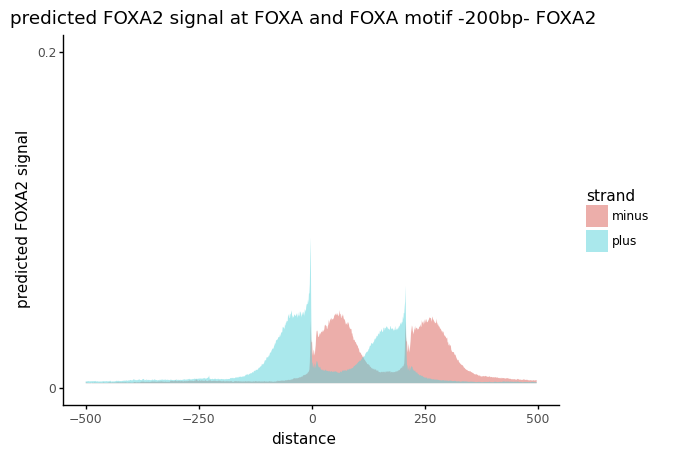

<ggplot: (8739896378665)>


/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/users/vir/miniconda2/envs/basepairmodels_latest/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: FOXA and FOXA motif -200bp- FOXA2.pdf


In [73]:
output_seq_len = 1000
number_of_strands = 2


motif1 = 'TGTTTACTTA'
motif2 = 'TGTTTACTTA'

input_seq_len = 2114
motif_inserted_sequences = []

sequences = get_suffled_peak_sequences(peak_path, reference_genome, 2114, 200)

motif_inserted_sequences = insert_two_motif_with_distance(motif_1=motif1,
                                                                  motif_2=motif2,
                                                                  distance=200,
                                                                  sequences=sequences)
encoded_inserted_sequences = one_hot_encode(motif_inserted_sequences)

prediction = model.predict([encoded_inserted_sequences,
               np.zeros(output_seq_len*number_of_strands*encoded_inserted_sequences.shape[0]).reshape((encoded_inserted_sequences.shape[0],1,output_seq_len,number_of_strands))])


plus,minus = calculate_average_profile(prediction)

data = pd.DataFrame([plus,minus,np.array(range(-500,499),dtype='int32')]).T
data.columns = ['plus','minus','distance']

data = pd.melt(data,id_vars='distance', 
           value_vars=['plus', 'minus'], 
           var_name='strand', 
           value_name='predicted signal')

ymin=min(data['predicted signal'])
plot=(ggplot(data,aes('distance'))
         +geom_ribbon(aes(ymin=ymin,ymax='predicted signal',fill='strand'),alpha=0.5)
         +theme_classic()
         +scale_y_continuous(name ="predicted FOXA2 signal",limits=(0,0.2),breaks=(0,0.2))
         +labs(title="predicted FOXA2 signal at FOXA and FOXA motif -200bp- FOXA2")  
     )
print(plot)
plot.save("FOXA and FOXA motif -200bp- FOXA2.pdf")